# Pbar Globe 2nd Try

I think I need a clean slate where I can start at the very beginning and test each step along the way. I'm assuming most/all of this code will be pulled from pbar_globe, but there's a lot going on there, and I tried to jump to the finish line and it didn't go well.

# Housekeeping

## Imports and plotting params

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [3]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [4]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load pre-made datasets

In [125]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p.nc').rename({'PRES_INTERPOLATED':'pressure','N_PROF':'prof','LATITUDE':'lat','LONGITUDE':'lon'})                #individual profiles where sampling rate <=2.5m, pressure grid
ds_r = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_r.nc').rename({'LATITUDE':'lat','LONGITUDE':'lon'})             #individual profiles where sampling rate <=2.5m, density grid

ds_p_grid3 = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p_grid3.nc')     #3x3 gridded dataset where sampling rate <=2.5m, pressure grid
ds_r_grid3 = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_rho_grid3.nc') #3x3 gridded dataset where sampling rate <=2.5m, density grid

RG_p = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_p.nc')
RG_r = xr.open_dataset('/swot/SUM05/amf2288/RG_clim/RG_r.nc')

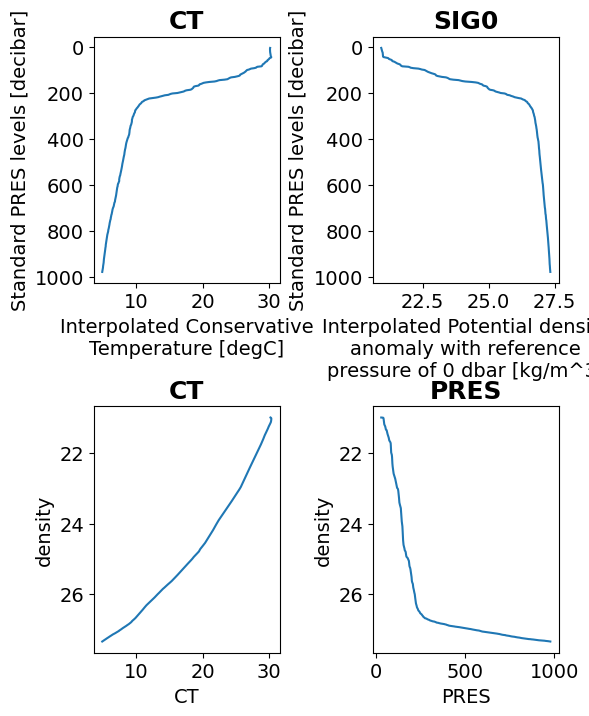

In [126]:
num = 832906
prof_p = ds_p.isel(prof=num)
prof_r = ds_r.isel(prof=num)

plt.figure(figsize=(6,8))
plt.subplot(221)
prof_p.CT.plot(y='pressure')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(222)
prof_p.SIG0.plot(y='pressure')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplot(223)
prof_r.CT.plot(y='density')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(224)
prof_r.PRES.plot(y='density')
plt.gca().invert_yaxis()
plt.title('PRES')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Create ds_pmean

## Construct $p-\rho$ relationship

In [127]:
def match_mean_profiles(ds_rho, pres_rho_gridded, lon_bins, lat_bins):

    lat_idx = np.digitize(ds_rho.lat.values, lat_bins) - 1
    lon_idx = np.digitize(ds_rho.lon.values, lon_bins) - 1

    valid = (lat_idx >= 0) & (lat_idx < len(pres_rho_gridded.lat)) & \
            (lon_idx >= 0) & (lon_idx < len(pres_rho_gridded.lon))

    matched_profiles = np.full((ds_rho.dims['prof'], ds_rho.dims['density']), np.nan, dtype=np.float32)
    matched_profiles[valid] = pres_rho_gridded.values[:, lon_idx[valid], lat_idx[valid]].T

    return xr.DataArray(matched_profiles, dims=('prof', 'density'),
                        coords={'prof': ds_rho.prof, 'density': ds_rho.density})

In [134]:
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [139]:
RG_r

<xarray.Dataset> Size: 725MB
Dimensions:  (lat: 59, lon: 120, density: 3200)
Coordinates:
  * lat      (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 78.0 81.0 84.0 87.0
  * lon      (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * density  (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
Data variables:
    CT       (density, lat, lon) float64 181MB ...
    SA       (density, lat, lon) float64 181MB ...
    SIG0     (density, lat, lon) float64 181MB ...
    PRES     (density, lat, lon) int64 181MB -9223372036854775808 ... -922337...

In [132]:
ds_rho['pres_mean'] = match_mean_profiles(ds_r, RG_r.PRES, lon_bins, lat_bins)

/tmp/ipykernel_24205/1453650102.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  matched_profiles = np.full((ds_rho.dims['prof'], ds_rho.dims['density']), np.nan, dtype=np.float32)


IndexError: index 118 is out of bounds for axis 1 with size 59

PROF lat: -77.81753666666667, lon: -161.898835
MEAN lat: -78.0, lon: -160.5


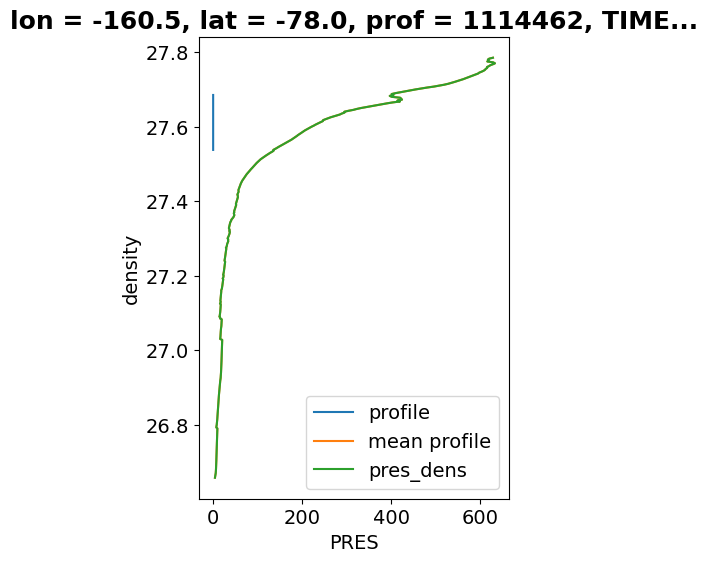

In [57]:
num = 39
prof = ds_rho.isel(prof=num)
mean = ds_rho_grid3.PRES.sel(lat=prof.lat, lon=prof.lon, method='nearest')
print(f'PROF lat: {prof.lat.values}, lon: {prof.lon.values}')
print(f'MEAN lat: {mean.lat.values}, lon: {mean.lon.values}')

plt.figure(figsize=(4,6))
prof.PRES.plot(y='density', label='profile')
prof.pres_dens.plot(y='density',  label='mean profile')
mean.plot(y='density', label='pres_dens')
plt.legend();

## Interpolate ds_rho to ds_pmean

In [ ]:
from scipy.ndimage import uniform_filter1d

def interp_to_pmean(var_profile, pres_dens, pmean_grid, roll=50):
    try:
        # Apply a centered moving average using a uniform filter
        pmean_smooth = uniform_filter1d(pres_dens, size=roll, mode='nearest', origin=0)

        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        return np.full_like(pmean_grid, np.nan)

In [ ]:
def get_ds_pmean(ds_rho, pmean_grid, variables, dim1='N_PROF', dim_dens='rho_grid', dim_pmean='pmean', roll=50):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], ds_rho['pres_dens'],
                                   input_core_dims=[['density'], ['density']],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1,'pmean_grid'],
            coords={'pmean_grid': pmean_grid, 'prof': ds_rho.prof},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(lat  = ('N_PROF', ds_rho.lat.data))
    ds_pmean = ds_pmean.assign_coords(lon = ('N_PROF', ds_rho.lon.data))
    #ds_pmean = ds_pmean.assign_coords(TIME      = ('N_PROF', ds_rho.TIME.data))
    
    return ds_pmean.rename({'pmean_grid':'pmean'})